![Detecting Cyberbullying with NLP](images/Cyberprzemoc.png)

# Detecting Cyberbullying with NLP

**Author: Greg Burgess**


In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline


from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag, FreqDist

from wordcloud import WordCloud

import pickle

pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300 # max width of a column

%matplotlib inline

In [2]:
# import nltk
# nltk.download('omw-1.4')

## Data Preparation

Begin by reading in new target data frame that was created at the end of the [prior notebook](./01-data-understanding.ipynb).

In [3]:
new_target_df = pd.read_csv('data/new_target_df.csv')
new_target_df.info(show_counts=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999515 entries, 0 to 1999514
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   id            1999515 non-null  int64 
 1   comment_text  1999515 non-null  object
 2   target        1999515 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 45.8+ MB


The total number of toxic posts is approaching 340,000.

In [4]:
is_target = (new_target_df['target'] == 1)
num_targets = sum(is_target)
num_targets

338409

Although the total number of toxic comments is large, the toxic comments comprise only 17% of all posts. This is a relatively moderate class imbalance. However, given the large number of posts available, I chose to undersample the non-toxic comment class in order to avoid issues with a class imbalance while training the model.

In [5]:
majority_df = resample(new_target_df[ is_target ],
                       replace=False,
                       n_samples=num_targets,
                       random_state=42)

minority_df = resample(new_target_df[ ~is_target ],
                       replace=False,
                       n_samples=num_targets,
                       random_state=42)

train_df = pd.concat([majority_df, minority_df])
train_df['target'].value_counts()

1    338409
0    338409
Name: target, dtype: int64

In [6]:
# # save training df to reuse it later without re-creating it
# train_df.to_csv('data/train_df.csv', index=False)

# # load train df so you don't need to re-create it
# train_df = pd.read_csv('data/train_df.csv')

### Text preprocessing functions

The ‘comment_text’ field requires standard "Bag of Words" preprocessing techniques for NLP:

- text cleaning
- remove stop words
- tokenization
- lemmatization
- vectorization

The functions below are set up to perform that preprocessing.

The lemmatizer requires part of speech for each word, in order to determine the correct lemma for each word. The nltk `pos_tag` method gives us part of speech, but it isn't in the format expected by the lemmatizer. The `get_wordnet_pos` function converts to the expected part of speech.

In [7]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

The `word_processor` function does the following:
- Uses RegexpTokenizer to find individual words in the `comment_text` string. The regex pattern will match one or more contiguous letters, and will include a subsequent apostrophe that is followed by more letters. Consequently, the output of the regex will remove punctuation.
- Converts characters to lowercase and removes stopwords in the supplied stopwords list
- Looks up the part of speech for a word, and inputs the word and part of speech into the lemmatizer.
- Joins the list of lemmas output by the lemmatizer back into a single string that can be used by a vectorizer

In [8]:
# Added 'us' to stopwords, because the lemmatizer reduces it to 'u'
sw = stopwords.words('english') + ['us']

def word_processor(comment, stopword_list=sw):
    # tokenize (simultaneously removes punctuation and numbers)
    tokenizer = RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)")
    words = tokenizer.tokenize(comment)

    # lowercase and remove stopwords
    words = [word.lower() for word in words if word.lower() not in stopword_list]
    
    # lemmatize (accounting for part of speech)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word[0], get_wordnet_pos(word[1])) 
             for word in pos_tag(words)]

    return ' '.join(words)

In [10]:
# Run the `comment_text` through the `word_processor` function and save output to `proc_text`
train_df['proc_text'] = train_df['comment_text'].map(word_processor)

In [11]:
# Look at `comment_text` and `proc_text` for 10 example comments
train_df.head(10)

,id,comment_text,target,proc_text
1841504,6130267,"I don't think I would be acting like a tough guy in front of my kid with a bat if the other guy had a gun.doesn't seem like much of a fight to me,but then most people don't bring bats to gun fights",1,think would act like tough guy front kid bat guy gun seem like much fight people bring bat gun fight
1932471,6120855,"The Left will always defends scum like this, as long as their politics are ""correct"". \n\nYet, Democrats and the Left are the ones that claim to want to defend women's rights ... the truth tells a far different story.",1,leave always defend scum like long politics correct yet democrats left one claim want defend women's right truth tell far different story
1807493,6233267,"I think they will be fighting Hawaiian, Alaska/Virgin America, Delta, United , American Airlines for gate space during peak times at HNL. They all use or will be using medium size aircraft and fight with Wide bodies during this period. State is retrofitting the diamond head concourse for Island...",1,think fight hawaiian alaska virgin america delta united american airline gate space peak time hnl use use medium size aircraft fight wide body period state retrofit diamond head concourse island air would accommodate sw enter inter island market somebody pay island air go
1984715,452907,"Bad: As pepper spray does not threaten serious bodily harm, nor a reasonable possibility of death, you would probably be prosecuted for use of unjustifiable deadly force. And I was relieved to see you describe yourself as an ""ex-cop"". I would be fearful of having to deal with you if you were ...",1,bad pepper spray threaten serious bodily harm reasonable possibility death would probably prosecute use unjustifiable deadly force relieve see describe ex cop would fearful deal still force
1648881,5494517,The fascist movements that threaten us is these twisted ugly leftist hate groups trying to destroy democracy and freedom of religion and freedom of speech disguised as liberalism?.\nYou accept no other opinion but your own.\nYou would destroy freedom instead of admitting you are wrong.\nWe are t...,1,fascist movement threaten twist ugly leftist hate group try destroy democracy freedom religion freedom speech disguise liberalism accept opinion would destroy freedom instead admit wrong try stop islamist take country culture way life get blow either age f u lefty fascism think gonna let destroy...
1357581,495247,"A rather cruel irony piece you've here likely unintentionally penned. The pain of the PFD cut is going to be felt far more deeply by more people outside your consciousness's target demographic than you likely considered. Or rather, never have to consider. Nor will. Burning the PFD on ""Vacation G...",1,rather cruel irony piece likely unintentionally pen pain pfd cut go felt far deeply people outside consciousness's target demographic likely consider rather never consider burn pfd vacation getaway particularly egregious hard time comin already many fellow alaskan must young buoyant rosy cheek o...
1530830,568633,"Egad, it's nefarious!",1,egad nefarious
132118,6142987,"First it was all these Liberals geniuses saying America would never dump NAFTA. Now after seeing their stupidity splashed all over the front pages of every newspaper they are realizing they are so far behind they have no way to catch up.\n\nThey have been outplayed, outmaneuvered, outgunned, and...",1,first liberal genius say america would never dump nafta see stupidity splash front page every newspaper realize far behind way catch outplay outmaneuvered outgunned show utter fool thus see g article alternative help soften blow town clown own period trump killer schmuck hack washington try true...
593230,5809512,"Jim Fowler is a naive inept and inexperienced tennis commentator. He bores us with usless information during a broadcast. Asking the tennis professionals in the booth stupid questions during points and pushing for an answer during game poin

### Review most frequent terms

Now that the `comment_text` has been preprocessed, we can use CountVectorizer to create the matrix of word counts. Setting `min_df=0.0001` drops any low frequency words that occur in less than 1 out of 10,000 comments.

In [12]:
cv = CountVectorizer(min_df=0.0001)
count_matrix = cv.fit_transform(train_df['proc_text'])

Now that I have the word counts for each comment in the total corpus, I can find the most frequent words (lemmas) in the corpus. To do this, I summed down each column to get a count of how often each word is used across all comments. Then, I zipped the counts with the corresponding word names into a dictionary, sorted the dictionary, and save the 20 most frequent words.

In [13]:
count_sum = count_matrix.sum(axis=0).tolist()[0]
feature_names = cv.get_feature_names_out()
frequencies = dict(zip(feature_names, count_sum))
top_terms = dict(sorted(frequencies.items(), key=lambda x:x[1], reverse=True)[:20])
top_terms.keys()

dict_keys(['people', 'get', 'trump', 'would', 'like', 'one', 'go', 'make', 'say', 'think', 'know', 'time', 'year', 'right', 'need', 'take', 'good', 'well', 'see', 'want'])

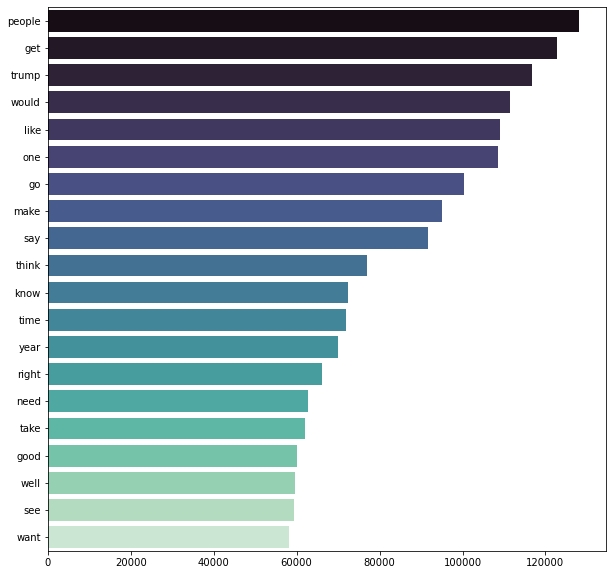

In [15]:
# Create a barplot of the 20 most frequent words
top_terms_df = pd.Series(top_terms)
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x=top_terms_df.values, y=top_terms_df.index, ax=ax, palette="mako");
#plt.savefig('images/FreqDist.jpg', transparent = False, bbox_inches="tight")

### Review words specific to each class

The most frequent words did not appear to be terms that would distinguish between toxic and non-toxic comments. 

So, I separated the comments by `target` class, re-counted the occurrences within each class, and found the most frequent words for each class separately.

In [16]:
is_target = (train_df['target'] == 1)

bully_train_df = train_df[is_target]['proc_text']
nonbully_train_df = train_df[~is_target]['proc_text']

Find 200 most frequent words for `bully` (toxic) class.

In [17]:
bully_count_matrix = cv.fit_transform(bully_train_df)

In [18]:
bully_count_sum = bully_count_matrix.sum(axis=0).tolist()[0]
bully_feature_names = cv.get_feature_names_out()
bully_frequencies = dict(zip(bully_feature_names, bully_count_sum))
top_bully_terms = dict(sorted(bully_frequencies.items(), key=lambda x:x[1], reverse=True)[:200])

Find 200 most frequent words for `nonbully` (non-toxic) class.

In [19]:
nonbully_count_matrix = cv.fit_transform(nonbully_train_df)

In [20]:
nonbully_count_sum = nonbully_count_matrix.sum(axis=0).tolist()[0]
nonbully_feature_names = cv.get_feature_names_out()
nonbully_frequencies = dict(zip(nonbully_feature_names, nonbully_count_sum))
top_nonbully_terms = dict(sorted(nonbully_frequencies.items(), key=lambda x:x[1], reverse=True)[:200])

Now that we know the most frequent words for each class separately, let's determine which words are specific to the `bully` class (i.e., common in toxic comments, but not common in non-toxic comments)

In [21]:
# make dictionary of words in top bully terms but not in top nonbully terms
bully_specific_terms = []
for key in top_bully_terms.keys():
    if not key in top_nonbully_terms:
        bully_specific_terms.append(key)

print(bully_specific_terms)
bully_specific_frequencies = {key: bully_frequencies[key] for key in bully_specific_terms}

['white', 'kill', 'stupid', 'lie', 'black', 'racist', 'muslim', 'gun', 'america', 'hate', 'idiot', 'attack', 'men', 'hillary', 'clinton', 'kid', 'they', 're', 'head', 'name', 'democrat', 'group', 'act', 'crime', 'police', 'oh', 'death', 'll', 'feel', 'human', 'trudeau', 'hand']


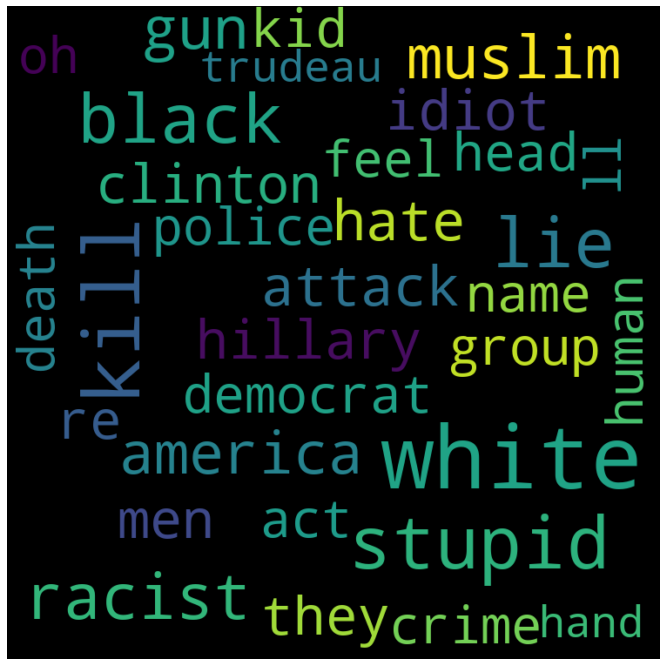

In [22]:
# make word cloud of bully specific terms
bully_wordcloud = WordCloud(min_font_size=10, max_font_size=100, 
                      width=750, height=750).generate_from_frequencies(bully_specific_frequencies);
#bully_wordcloud.to_file("../images/bully_wordcloud.png")
plt.rcParams['figure.figsize'] = [12, 12]
plt.figure()
plt.imshow(bully_wordcloud, interpolation="bilinear")
plt.axis("off");

Now let's find words that are specific to the nonbully class.

In [23]:
nonbully_specific_terms = []
for key in top_nonbully_terms.keys():
    if not key in top_bully_terms:
        nonbully_specific_terms.append(key)

print(nonbully_specific_terms)
nonbully_specific_frequencies = {key: nonbully_frequencies[key] for key in nonbully_specific_terms}

['cost', 'city', 'http', 'oil', 'alaska', 'home', 'question', 'best', 'less', 'story', 'company', 'include', 'com', 'write', 'interest', 'plan', 'church', 'move', 'health', 'www', 'least', 'increase', 'next', 'number', 'low', 'service', 'mr', 'fund', 'income', 'buy', 'etc', 'provide']


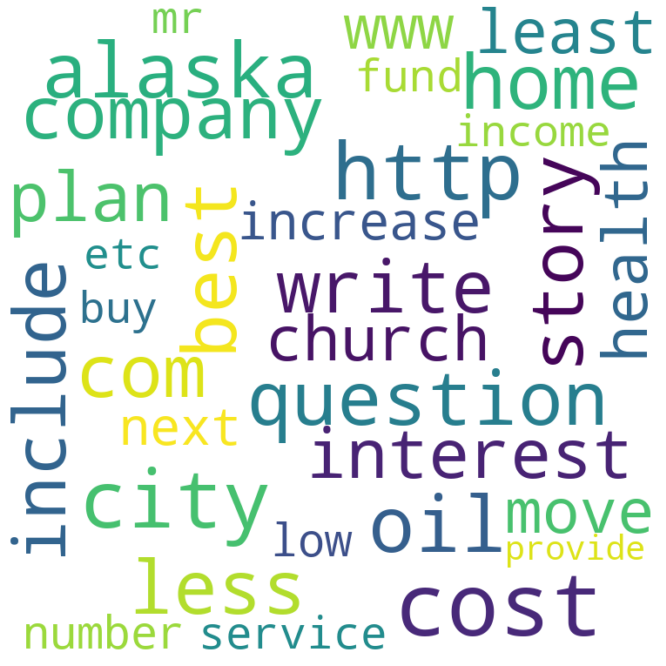

In [24]:
nonbully_wordcloud = WordCloud(min_font_size=10, max_font_size=100, 
                      width=750, height=750,
                      background_color='white').generate_from_frequencies(nonbully_specific_frequencies);
#nonbully_wordcloud.to_file("../images/nonbully_wordcloud.png")
plt.rcParams['figure.figsize'] = [12, 12]
plt.figure()
plt.imshow(nonbully_wordcloud, interpolation="bilinear")
plt.axis("off");

After exploring these preprocessing techniques, we can move to the [pipelines and models](./03-pipelines-and-models.ipynb) notebook.